In [1]:
%matplotlib inline
## Run this cell once before the lab to download
## the mnist dataset and the pre-trained ResNet50 model. 

## Mnist
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

## Keras pre-trained weights
from keras.utils.data_utils import get_file
get_file('resnet50_weights_tf_dim_ordering_tf_kernels.h5',
         'https://github.com/fchollet/deep-learning-models/releases'+
         '/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels.h5',
         cache_subdir='models',
         md5_hash='a7b3fe01876f51b976af0dea6bc144eb')

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Using TensorFlow backend.


'/home/ogrisel/.keras/models/resnet50_weights_tf_dim_ordering_tf_kernels.h5'

# Convolutional Neural Networks

Objectives:
- TensorFlow tutorial
- Application of convolution on images
- First conv net on MNIST with TensorFlow
- Use a pre-trained ResNet with Keras for transfer learning (second notebook)

Home assignment: fine-tuning a resnet on GPU (third notebook)

## TensorFlow 101

TensorFlow is a symbolic graph computation engine, that allows automatic differentiation of each node
- https://www.tensorflow.org 
- https://www.tensorflow.org/tutorials/mnist/tf/

TensorFlow builds where nodes may be:
- **constant:** constants tensors, such as a learning rate
- **Variables:** any tensor, such as parameters of the models
- **Placeholders:** placeholders for inputs and outputs of your models
- many other types of nodes (functions, loss, ...)

The graph is symbolic, no computation is performed until a `Session` is defined and the command `run` or `eval` is invoked. TensorFlow may run this computation on (multiple) CPUs or GPUs

In [2]:
import tensorflow as tf

a = tf.constant(3)
b = tf.constant(2)
c = a + b

In [3]:
print(type(a))
print(a)

<class 'tensorflow.python.framework.ops.Tensor'>
Tensor("Const:0", shape=(), dtype=int32)


In [4]:
print(type(c))
print(c)

<class 'tensorflow.python.framework.ops.Tensor'>
Tensor("add:0", shape=(), dtype=int32)


In [5]:
with tf.Session() as sess:
    c_value = sess.run(c)
    
print(type(c_value))
print(c_value)

<class 'numpy.int32'>
5


In [6]:
d = tf.Variable(0)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(d))

    sess.run(d.assign_add(c))
    print(sess.run(d))

    sess.run(d.assign_add(c))
    print(sess.run(d))

0
5
10


#### Input placeholders

- The placeholder is a variable that doesn't have a value yet in the symbolic graph. The value will be fed when running the session by passing the `feed_dict` argument
- If the placeholder is a k-dimensional tensor, we need to specify its shape. 
- It is possible to leave the shape variable by putting `None` values in the shape

In [7]:
x = tf.placeholder("float32", name="input")
y = x + tf.constant(3.0)

with tf.Session() as sess:
    print(sess.run(y, feed_dict={x: 2}))

5.0


In [8]:
import numpy as np

img = tf.placeholder("float32", shape=(1, 2, 3), name="input")
inverted_image = 255. - img

with tf.Session() as sess:
    fake_img = np.zeros(shape=(1, 2, 3))
    print(sess.run(inverted_image, feed_dict={img:fake_img}))

[[[ 255.  255.  255.]
  [ 255.  255.  255.]]]


In [9]:
img = tf.placeholder("float32", shape= [None, None, 3], name="input")
inverted_image = 255. - img
with tf.Session() as sess:
    fake_img = np.zeros(shape=(3, 2, 3))
    print(sess.run(inverted_image, feed_dict={img:fake_img}))

[[[ 255.  255.  255.]
  [ 255.  255.  255.]]

 [[ 255.  255.  255.]
  [ 255.  255.  255.]]

 [[ 255.  255.  255.]
  [ 255.  255.  255.]]]


### Reading and opening images

The following code enables to read an image, put it in a numpy array and display it in the notebook.

In [10]:
import tensorflow as tf
import numpy as np
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt

sample image shape: (600, 600, 3)


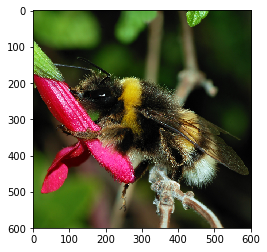

In [11]:
sample_image = imread("bumblebee.png")
sample_image= sample_image.astype(float)

size = sample_image.shape
print("sample image shape: "+ str(sample_image.shape))

def show(image):
    image = np.squeeze(image.astype("uint8"))
    plt.imshow(image, cmap="gray")

show(sample_image)

### A simple convolution filter

The goal of this section to use TensorFlow to perform convolutions on images. This section does not involve training any model yet.

We build a convolution filter that blurs the image using `tf.nn.depthwise_conv2d` (treats each channel separately)

In [12]:
image = tf.placeholder(tf.float32, shape=(None, None, None, 3))
kernel = tf.placeholder(tf.float32, shape=(5, 5, 3))

def conv(x, k):
    k = tf.reshape(k, shape=(5, 5, 3, 1))
    return tf.nn.depthwise_conv2d(x, k, strides=(1, 1, 1, 1),
                                  padding='SAME')
    
output_image = conv(image, kernel)
kernel_data = np.zeros(shape=(5, 5, 3)).astype(np.float32)
kernel_data[:, :, :] = 1 / 25

# move the channel dimension to the first dimension to
# make it easy to see the spacial organization of the kernel
# on the last 2 dimensions with print:
print(np.transpose(kernel_data, (2, 0, 1))) 

[[[ 0.04  0.04  0.04  0.04  0.04]
  [ 0.04  0.04  0.04  0.04  0.04]
  [ 0.04  0.04  0.04  0.04  0.04]
  [ 0.04  0.04  0.04  0.04  0.04]
  [ 0.04  0.04  0.04  0.04  0.04]]

 [[ 0.04  0.04  0.04  0.04  0.04]
  [ 0.04  0.04  0.04  0.04  0.04]
  [ 0.04  0.04  0.04  0.04  0.04]
  [ 0.04  0.04  0.04  0.04  0.04]
  [ 0.04  0.04  0.04  0.04  0.04]]

 [[ 0.04  0.04  0.04  0.04  0.04]
  [ 0.04  0.04  0.04  0.04  0.04]
  [ 0.04  0.04  0.04  0.04  0.04]
  [ 0.04  0.04  0.04  0.04  0.04]
  [ 0.04  0.04  0.04  0.04  0.04]]]


(1, 600, 600, 3)


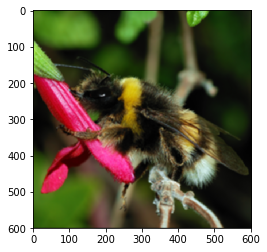

In [13]:
with tf.Session() as sess:
    feed_dict = {image: [sample_image], kernel: kernel_data}
    conv_img = sess.run(output_image, feed_dict=feed_dict)
    print(conv_img.shape)
    show(conv_img[0])

**Exercise**
- Build an identity 3x3 kernel with stride 2. What is the size of the output image?
- Change the padding to 'VALID'. What do you observe?

Identity 3x3x3 kernel:
[[[ 0.  0.  0.]
  [ 0.  1.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  1.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  1.  0.]
  [ 0.  0.  0.]]]
Shape of result with SAME padding: (1, 300, 300, 3)
Shape of result with VALID padding: (1, 299, 299, 3)


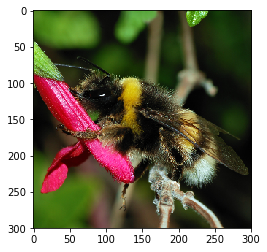

In [14]:
# %load solutions/strides_padding.py
image = tf.placeholder(tf.float32, [None, None, None, 3])
kernel = tf.placeholder(tf.float32, [3, 3, 3])

def conv(x, k):
    k = tf.reshape(k, shape=[3, 3, 3, 1])
    return tf.nn.depthwise_conv2d(x, k, strides=[1,2,2,1],
                                  padding='SAME')

def conv_valid(x, k):
    k = tf.reshape(k, shape=[3, 3, 3, 1])
    return tf.nn.depthwise_conv2d(x, k, strides=[1,2,2,1],
                                  padding='VALID')

output_image = conv(image, kernel)
output_image_valid = conv_valid(image, kernel)
kernel_data = np.zeros(shape=(3, 3, 3)).astype(np.float32)

# identity kernel: ones only in the center of the filter
kernel_data[1, 1, :] = 1
print('Identity 3x3x3 kernel:')
print(np.transpose(kernel_data, (2, 0, 1)))

with tf.Session() as sess:
    feed_dict = {image: [sample_image], kernel: kernel_data}
    conv_img, conv_img_valid = sess.run([output_image, output_image_valid],
                                        feed_dict=feed_dict)

    print("Shape of result with SAME padding:", conv_img.shape)
    print("Shape of result with VALID padding:", conv_img_valid.shape)
    show(conv_img[0])

# We observe that the stride divided the size of the image by 2
# In the case of 'VALID' padding mode, no padding is added, so 
# the size of the ouput image is actually 1 less because of the
# kernel size

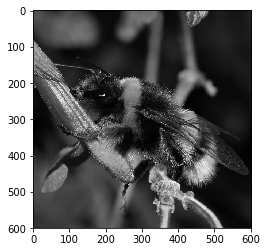

In [15]:
# convert image to greyscale
grey_sample_image = sample_image.sum(axis=2) / 3.

# add the channel dimension even if it's only one channel
grey_sample_image = grey_sample_image[:, :, np.newaxis]

show(grey_sample_image)

**Exercise**
- Build an edge detector using `tf.nn.conv2d` on greyscale image
- You may experiment with several kernels to find a way to detect edges
- https://en.wikipedia.org/wiki/Kernel_(image_processing)

Try `tf.nn.conv2d?` or press `shift-tab` to get the documentation. You may get help at https://www.tensorflow.org/api_docs/python/nn/convolution

[[ 0.   0.2  0. ]
 [ 0.  -0.2  0. ]
 [ 0.   0.   0. ]]
Resulting image shape: (1, 600, 600, 1)


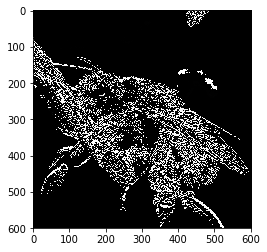

In [16]:
# %load solutions/edge_detection
image = tf.placeholder(tf.float32, [None, None, None, 1])
kernel = tf.placeholder(tf.float32, [3, 3])

def conv(x, k):
    k = tf.reshape(k, shape=[3, 3, 1, 1])
    return tf.nn.conv2d(x, k, strides=[1, 1, 1, 1],
                        padding='SAME')
    
output_image = conv(image, kernel)

kernel_data = np.array([
        [0.0,  0.2, 0.0],
        [0.0, -0.2, 0.0],
        [0.0,  0.0, 0.0],
    ])
# kernel_data = np.array([
#         [ 0.1,  0.2,  0.1],
#         [ 0.0,  0.0,  0.0],
#         [-0.1, -0.2, -0.1],
#     ])
print(kernel_data)

with tf.Session() as sess:
    feed_dict={image:[grey_sample_image], 
               kernel: kernel_data}
    conv_img = sess.run(output_image, feed_dict=feed_dict)
    print("Resulting image shape:", conv_img.shape)
    show(conv_img[0])

# We only showcase a vertical edge detection here.
# Many other kernels work, for example differences
# of centered gaussians (sometimes called mexican-hat
# connectivity)

### Pooling and strides with convolutions

**Exercise**
- Use `tf.nn.max_pool` to apply a 2x2 max pool to the image
- Use `tf.nn.avg_pool` to apply an average pooling.
- Is it possible to compute a max pooling and an average pooling with well chosen kernels?

**bonus**
- Implement a 3x3 average pooling with a regular convolution `tf.nn.conv2d`, with well chosen strides, kernel and padding

max pooling output shape: (1, 300, 300, 3)


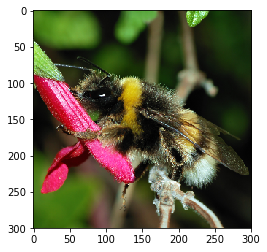

In [17]:
# %load solutions/pooling.py
image = tf.placeholder(tf.float32, [None, None, None, 3])
output_image = tf.nn.max_pool(image, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

with tf.Session() as sess:
    feed_dict={image:[sample_image], kernel: kernel_data}
    conv_img = sess.run(output_image, feed_dict=feed_dict)
    print("max pooling output shape:", conv_img.shape)
    show(conv_img[0])

# it is not possible to build a max pooling with a regular convolution
# however it is possible to build average pooling with well  
# chosen strides and kernel


(1, 200, 200, 3) (1, 200, 200, 3)


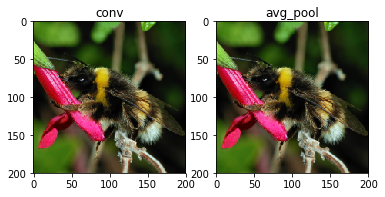

In [18]:
# %load solutions/average_as_conv.py
image = tf.placeholder(tf.float32, [None, None, None, 3])
kernel = tf.placeholder(tf.float32, [3, 3, 3, 3])

def conv(x, k):
    return tf.nn.conv2d(x, k, strides=[1, 3, 3, 1],
                        padding='SAME')

output_image = conv(image, kernel)
output_pool = tf.nn.avg_pool(image, ksize=[1, 3, 3, 1],
                             strides=[1, 3, 3, 1],
                             padding='SAME')

kernel_data = np.zeros(shape=(3, 3, 3, 3)).astype(np.float32)
kernel_data[:, :, 0, 0] = 1 / 9.
kernel_data[:, :, 1, 1] = 1 / 9.
kernel_data[:, :, 2, 2] = 1 / 9.

with tf.Session() as sess:
    feed_dict = {image: [sample_image], kernel: kernel_data}
    conv_img, pool_img = sess.run([output_image, output_pool],
                                  feed_dict=feed_dict)
    print(conv_img.shape, pool_img.shape)
    plt.subplot(1, 2, 1)
    show(conv_img[0])
    plt.title("conv")
    plt.subplot(1, 2, 2)
    show(pool_img[0])
    plt.title("avg_pool")

# Note that the numerical computation/approximation might
# be slightly different in the two cases

# Building a network on MNIST

https://www.tensorflow.org/tutorials/mnist/pros/

- Using Tensorflow
- Training data preprocessed
- Include regularization methods

### A simple feedforward model in TensorFlow 

- A logistic regression without taking into account the spatiality of the data
- Very similar to lab01

In [19]:
# MNIST is 28x28 = 784 dimensions
x = tf.placeholder(tf.float32, shape=[None, 784])
y_true = tf.placeholder(tf.float32, shape=[None, 10])

W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

y_pred = tf.matmul(x,W) + b

# We don't have to do the softmax ourselves, TensorFlow can use
# logits directly to compute the loss
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(y_pred, y_true)
loss = tf.reduce_mean(cross_entropy)
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_pred,1), tf.argmax(y_true,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [20]:
with tf.Session() as sess:
    # Initialize weights
    sess.run(tf.global_variables_initializer())

    # Train loop
    for i in range(1000):
        # mnist.train helper function builds a batch of N elements
        batch = mnist.train.next_batch(100)
        train_step.run(feed_dict={x: batch[0], y_true: batch[1]})
        
    feed_dict={x: mnist.test.images, 
               y_true: mnist.test.labels}
    print(accuracy.eval(feed_dict=feed_dict))

0.917


### CNN model in TensorFlow

You are going to build a convolutional neural network with TensorFlow.

The following helper functions were taken from TensorFlow tutorial https://www.tensorflow.org/tutorials/mnist/pros/

They allow:
- to define weights and bias by only specifying the shape
- easy use of convolutions and max_pool layers

In [21]:
# Helper functions

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

In order to use the spatial geometry of the image, we reshape the input tensor to (`batch_size, 28, 28, channel_number`)

In [22]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_true = tf.placeholder(tf.float32, shape=[None, 10])

# only 1 channel (grey image) and the batch size is -1 because
# we don't know its size beforehand
x_image = tf.reshape(x, (-1, 28, 28, 1))
print(x_image.get_shape())

(?, 28, 28, 1)


In [23]:
with tf.Session() as sess:
    batch = mnist.train.next_batch(10)
    x_value, x_image_value = sess.run(
        [x, x_image], feed_dict={x: batch[0]})
    
    print(x_value.shape, x_image_value.shape)

(10, 784) (10, 28, 28, 1)


In [24]:
# Convolution layer example in TensorFlow
W_conv1 = weight_variable([5, 5, 1, 32])
h_conv1 = conv2d(x_image, W_conv1)
h_pool1 = max_pool_2x2(h_conv1)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    batch = mnist.train.next_batch(10)
    output_conv, output_pool = sess.run(
        [h_conv1, h_pool1], feed_dict={x: batch[0]})
    
    print("conv activation shape:", output_conv.shape)
    print("pool activation shape:", output_pool.shape)

conv activation shape: (10, 28, 28, 32)
pool activation shape: (10, 14, 14, 32)


** Exercise **

Build a CNN with the following architecture:
- Convolution 5x5, 32 output channels + bias
- ReLU (you may use `tf.nn.relu`)
- Maxpool 2x2
- Convolution 5x5, 64 output channels + bias
- ReLU
- Maxpool 2x2
- Fully connected layer of size 1024 (you may use `tf.reshape(x, [-1, size])`)
- ReLU
- Output fully connected layer of size 10 
- The output should be named `y_conv`

**Bonus** add dropout
- A 50% dropout should work here
- You may use `tf.nn.dropout(x, keep_prob)`
- You should add keep prob as an input of the model, and pass 0.5 during training and 1.0 during test time

In [25]:
# %load solutions/mnist_conv.py
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)
h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])

W_fc1 = weight_variable([7 * 7 * 64, 256])
b_fc1 = bias_variable([256])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

W_fc2 = weight_variable([256, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1, W_fc2) + b_fc2


In [26]:
# softmax and loss
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(y_conv, y_true)
loss = tf.reduce_mean(cross_entropy)

# optimizer
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

# accuracy
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_true,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(500):
        batch = mnist.train.next_batch(50)
        if i%100 == 0:
            feed_dict = {x:batch[0], y_true: batch[1]}
            train_accuracy = accuracy.eval(feed_dict=feed_dict)
            print("step %d, training accuracy %g"
                  % (i, train_accuracy))
        feed_dict = {x: batch[0], y_true: batch[1]}
        train_step.run(feed_dict = feed_dict)
        
    feed_dict = {x: mnist.test.images[:1000],
                 y_true: mnist.test.labels[:1000]}
    print("test accuracy %g" % accuracy.eval(feed_dict=feed_dict))

step 0, training accuracy 0.14
step 100, training accuracy 0.88
step 200, training accuracy 0.88
step 300, training accuracy 0.92
step 400, training accuracy 0.96
test accuracy 0.929


In [27]:
# %load solutions/mnist_conv_dropout.py
# Model definition
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)
h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])

W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# Loss function and optimizer
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(y_conv, y_true)
loss = tf.reduce_mean(cross_entropy)

train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

# Metrics
correct_prediction = tf.equal(tf.argmax(y_conv, 1),
                              tf.argmax(y_true, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Main training loop
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(500):
        batch = mnist.train.next_batch(50)
        if i % 100 == 0:
            # no dropout
            feed_dict = {x:batch[0], y_true: batch[1], keep_prob: 1.0}
            train_accuracy = accuracy.eval(feed_dict=feed_dict)
            print("update %d, training accuracy %g"
                  % (i, train_accuracy))
        # dropout
        feed_dict = {x:batch[0], y_true: batch[1], keep_prob: 0.5}
        train_step.run(feed_dict = feed_dict)
    # no dropout
    feed_dict = {x: mnist.test.images,
                 y_true: mnist.test.labels, keep_prob: 1.0}
    print("test accuracy %g" % accuracy.eval(feed_dict = feed_dict))


update 0, training accuracy 0.02
update 100, training accuracy 0.84
update 200, training accuracy 0.92
update 300, training accuracy 0.94
update 400, training accuracy 0.88
test accuracy 0.9426
